## Object Detection Via Sliding Images process
### We will detect object using sliding images process and can able to draw bounding boxes of the image.
#### Steps: 1. We will have a classic object detection model
#### 2. Create pyramid search images with different sizes
#### 3. Slide through every images just like convolution layer
#### 4. Predict images from all the slided cum pyramid search images
#### 5. Use Non-Max suppression process to eliminate duplicate bounding boxes.

### Import Dependencies

In [ ]:
import numpy as np
import matplotlib.pyplot as plt ## For plotting
import tensorflow as tf
### object detection libraries
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import decode_predictions
from tensorflow.keras.applications import imagenet_utils

### Image handling library
import cv2
from PIL import Image
## time libraries
import time

### Model Loading

In [ ]:
model= ResNet50(include_top= True, weights='imagenet')

102973440/102967424 [==============================] - 1s 0us/step


##### Function to Display image

In [ ]:
def display_image(image):
  fig= plt.figure(figsize=(8,8))
  plt.grid(False)
  plt.imshow(image)
  plt.show()

#### Loading image

In [ ]:
image_path='/images/hummingbird.jpg'
pil_image= Image.open(image_path)

##Convert image to array
humming= np.array(pil_image)

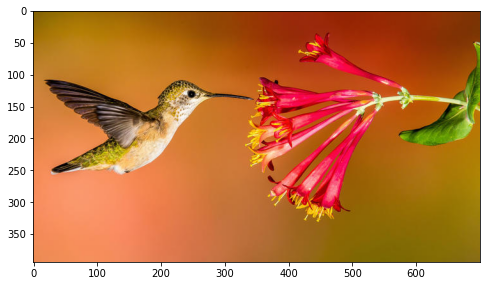

In [ ]:
display_image(humming)

### Load input parameters
#### We will assign default variables like 
##### inpu_size: This is defined to pass image to model with respective input params
##### roi_size: size of the image should be when sliding an image, This can be defined as per requirement.
##### strides to perform: to how many pixels image has to slide for each step. This is like stride in CNN
##### pyramid scale value  : Reducing the size of the image in each step untill it reaches the desired roi_size
##### width_scale: The initial size of the image

In [ ]:
width_scale= 600
roi_size=(150,200)
input_size=(224, 224)
strides=16
pyr_scale=1.5

### Pyramid Images
#### We will reduce the image size by the scale mentioned
#### Process is continued untill it raches size of Roi

In [ ]:
## Function for Pyramid image search
def pyramid_image(pyr_image, pyr_scale, roi_size):
  roi_height_limitexceed= False
  roi_width_limitexceed= False

  yield pyr_image

  pyr_h, pyr_w= pyr_image.shape[:2]

  while True:
    pyr_h, pyr_w= pyr_image.shape[:2]
    scale_h= int(pyr_h/ pyr_scale)
    scale_w= int(pyr_w/pyr_scale)

    if scale_h <= roi_size[0]:
      roi_height_limitexceed= True
    
    else:
      pyr_h= scale_h
    
    if scale_w <= roi_size[1]:
      roi_width_limitexceed= True
    
    else:
      pyr_w= scale_w
    
    ## If height and width exceeds roi size then break the loop
    if roi_height_limitexceed==True and roi_width_limitexceed==True:
      break
    
    ### Resize the current image to scaled factor
    pyr_image= cv2.resize(pyr_image, (pyr_w, pyr_h), interpolation=cv2.INTER_AREA)
    yield pyr_image

#### Lets test it

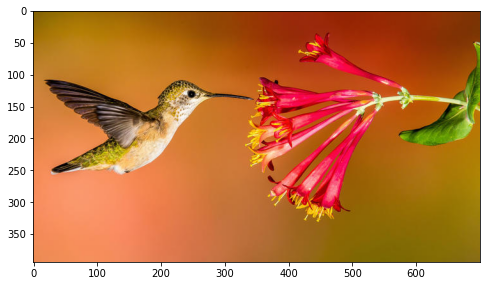

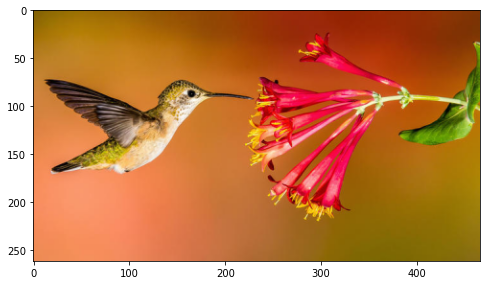

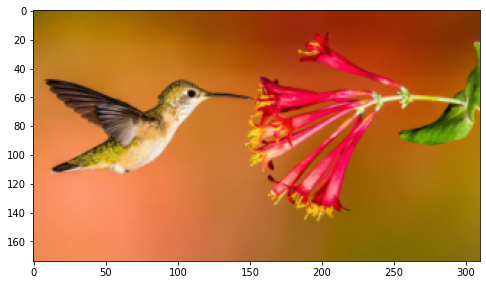

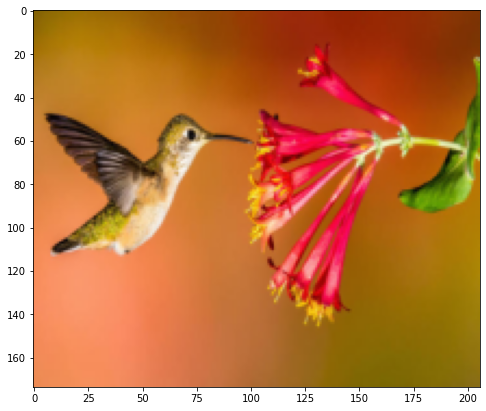

In [ ]:
for pyr_image in pyramid_image(humming, pyr_scale, roi_size):
  display_image(pyr_image)

### Sliding window process
#### a shape is considered initially (roisize) and slided over the image horizontally and vertically and stores the images.
#### This process is repeated with all the pyramid images generated above.

In [ ]:
## Function of sliding window
def sliding_window(slide_image, strides, roi_size):

  slide_h, slide_w= slide_image.shape[:2]

  ### slide over y-axis
  for y in range(0,slide_h- roi_size[0], strides ):

    ##Slide over x-Axis
    for x in range(0, slide_w-roi_size[1], strides):
      yield (x, y, slide_image[y:y+roi_size[0], x:x+roi_size[1]])

### Apply sliding process for each pyramid image

In [ ]:
rois=[]# To store Roi images
locs=[]## To store co-ordinates of Roi images
for pyr_image in pyramid_image(humming, pyr_scale, roi_size):
  ### This is the scale where we multiply to each co=ordinate to get the actualy co-ordinates of the image
  #### When ever the image size is reduced the co-ordinates of Roi is also chagned
  #### When we divide the actual length with the changed length we will get the rate of change of length
  #### If we multiply that rate with all the co-ordinates we will get the actual image co-ordinates
  change_scale= width_scale / pyr_image.shape[1]
  print(change_scale)
  for (x, y, slide_image) in sliding_window(pyr_image, strides, roi_size):

    ### building the co-ordinates
    x= int(x * change_scale)
    y= int(y * change_scale)
    w= int(roi_size[1] * change_scale)
    h= int(roi_size[0] * change_scale)

    ### Load co-ordinates to locs list
    box= (x, y, x+w, y+h)
    locs.append(box)

    ### Create Roi
    ### Resize image to input_size
    roi= cv2.resize(slide_image, input_size, interpolation= cv2.INTER_AREA)
    roi= np.asarray(roi, dtype= np.float32)
    rois.append(roi)


0.8571428571428571
1.2875536480686696
1.935483870967742
2.912621359223301


### Pre-Process the images and predict the model

In [ ]:
###Conver list to aray
rois= np.array(rois)
## Preproces the data
preprocess_rois= preprocess_input(rois)
## Predict the data
prediction= model.predict(preprocess_rois)
## decode the prediction
decode_pred= imagenet_utils.decode_predictions(prediction)

In [ ]:
#### We will create highest confidence dict with labels and bounding box which has highest confidence
humming_clone= humming.copy()
highest_confi={}
for i, pred_image in enumerate(decode_pred):

  ### There would be list of tuples with all the probabilities which equates to 1. like softmax
  ### The list would be in descending order. We wil consider only first item which in general has highest prob
  (predict_id, label, confidence)= pred_image[0]

  if confidence >0.999999:
    box= locs[i]

    image_co_ord= highest_confi.get(label, [])
    image_co_ord.append((box, confidence))
    highest_confi[label]= image_co_ord

    print(label, confidence)
    ## Draw the image in the sample
    (x1, y1, x2, y2)= box
    cv2.rectangle(humming_clone, (x1,y1), (x2, y2), color=(0,255,0), thickness=5)
    

hummingbird 0.99999917
hummingbird 0.9999994
hummingbird 0.99999976
hummingbird 0.9999993
hummingbird 0.99999917
hummingbird 0.9999993


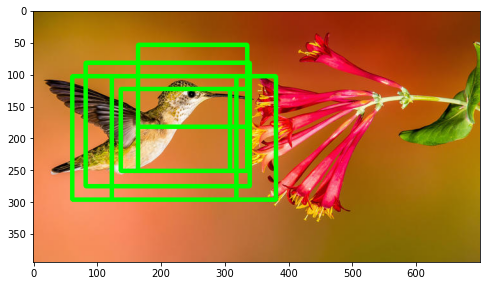

In [ ]:
display_image(humming_clone)

### Non-Max Suppression
#### Generally this process eliminates the duplicate bbx
#### Procedure: For each label with set of bbx we will calculate the area of the all boxes
#### Them we will take the highest confidence box and make the other boxes do not cross the boundaries of highest confidence box.
#### i.e, co-ordinates which are outer the highest confidence box will be re arranged with the co-ordinates of highest box if they crosses the boundary. otherwise it stays there. 

In [ ]:
humming_clone= humming.copy()
### Loop for each label
for label in highest_confi.keys():
  ### picks all the boxes for each label
  pick=[]

  ### Let us calculate the area of the bbx
  boxes=np.array([p[0] for p in highest_confi[label]])
  confidence= np.array([p[1] for p in highest_confi[label]])
  
  ### make sure the co-ordinates are floats
  boxes= boxes.astype(np.float32)
  #print(boxes.dtype)

  x1= boxes[:, 0]
  y1= boxes[:, 1]
  x2= boxes[:, 2]
  y2= boxes[:, 3]

  area= (x2 - x1 + 1) * (y2 - y1 + 1)

  ### index is created with confidence by ascending order
  ### Sorting the indx
  idx= np.argsort(confidence)
  #print(idx)

  ## Loop till there are no elements in the index
  while len(idx)>0:
    #print(len(idx))

    ### Take the last element which means the highest confidence form theindex
    last= len(idx)-1
    i= idx[-1]
    

    ### pick the index value
    pick.append(i)

    ### Take the new co-ordinates and calculate the area
    #### WE will make sure that remaining co-ordinates won't cross the limits of highest confidence bbx
    xx1= np.maximum(x1[i], x1[idx[:last]])
    yy1= np.maximum(y1[i], y1[idx[:last]])
    xx2= np.minimum(x2[i], x2[idx[:last]])
    yy2= np.minimum(y2[i], y2[idx[:last]])
    

    w= np.maximum(0, xx2-xx1+1)
    h= np.maximum(0, yy2-yy1+1)

    new_area= w * h
    print( new_area, area[:last])

    ### By divinding new are with old area we will get the percentage of reduction of the old area
    ### If the percentage is more then these boxes are belongs same object in the image(there might be
    ###  different objects with the same label)
    ### We call this as overlap. If overlap is > 0.3 then we will remove those index values and keep the remaining
    ### for next detection.

    overlap= new_area/area[:last]

    ### Remove values from overlap >0.3
    overlap_cross= np.where (overlap>0.3)
    #print(overlap)

    ##Concatenate last element as we already considered it.
    concatenate= np.concatenate(([last], overlap_cross[0]))

    ### delete all the above from idx
    idx= np.delete(idx, concatenate)
  #print(idx, last)
  
  ### Draw all the boxes of particular label from pick list
  for pick_box in pick:
    #print(pick_box)
    ## Co-ordinates
    (startx, starty, endx, endy)= boxes[pick_box]

    cv2.rectangle(humming_clone, (startx, starty), (endx, endy), color=(0,255,0), thickness=5)

  




[10320. 19995. 22188. 22188. 18705.] [22188. 22188. 22188. 50052. 50052.]


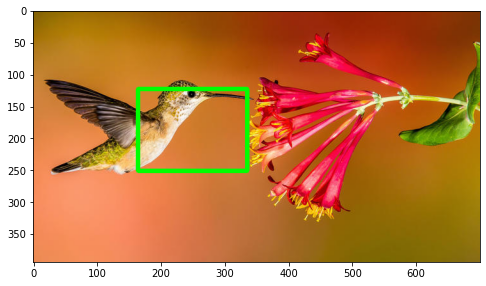

In [ ]:
display_image(humming_clone)